In [41]:
# !pip install --upgrade -q pip 
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade -q flax einops clu
# !pip install --upgrade tensorflow-probability
# !pip install --upgrade tensorflow-datasets
# !pip install jetnet

In [269]:
import jax
import jax.numpy as np
from jax import random, vmap, grad, jit
import numpy as onp
import matplotlib.pyplot as plt
import flax
import flax.linen as nn
import optax
import einops
from tqdm import tqdm, trange
import tensorflow_probability.substrates.jax as tfp
from scipy.stats import describe
import functools
from functools import partial
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type="GPU")
import tensorflow_datasets as tfds

tfd = tfp.distributions
tfb = tfp.bijectors
from clu import deterministic_data

In [270]:
import sys
sys.path.append("../")

from models.transformer import Transformer

In [271]:
def param_count(pytree):
    return sum(x.size for x in jax.tree_leaves(pytree))


replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [272]:
def create_input_iter(ds):
    def _prepare(xs):
        def _f(x):
            x = x._numpy()
            return x

        return jax.tree_util.tree_map(_f, xs)

    it = map(_prepare, ds)
    it = flax.jax_utils.prefetch_to_device(it, 2)
    return it

In [273]:
def gamma(ts, gamma_min=-6, gamma_max=6):
    return gamma_max + (gamma_min - gamma_max) * ts


def sigma2(gamma):
    return jax.nn.sigmoid(-gamma)


def alpha(gamma):
    return np.sqrt(1 - sigma2(gamma))

In [274]:
def variance_preserving_map(x, gamma, eps):
    a = alpha(gamma)
    var = sigma2(gamma)

    x_shape = x.shape

    x = x.reshape(x.shape[0], -1)
    eps = eps.reshape(eps.shape[0], -1)

    noise_augmented = a * x + np.sqrt(var) * eps

    return noise_augmented.reshape(x_shape)

In [275]:
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [276]:
class ScoreNet(nn.Module):
    embedding_dim: int = 32

    @nn.compact
    def __call__(self, z, g_t, conditioning):

        n_embd = self.embedding_dim

        t = g_t
        assert np.isscalar(t) or len(t.shape) == 0 or len(t.shape) == 1
        t = t * np.ones(z.shape[0])  # ensure t is a vector

        temb = get_timestep_embedding(t, n_embd)

        cond = np.concatenate([temb, conditioning], axis=1)
        # cond = nn.swish(nn.Dense(features=n_embd * 4, name="dense0")(cond))
        # cond = nn.swish(nn.Dense(features=n_embd * 4, name="dense1")(cond))
        # cond = nn.Dense(n_embd)(cond)

        h = jax.vmap(Transformer(n_input=3))(z, cond)

        return z + h

In [277]:
class VDM(nn.Module):
    timesteps: int = 1000
    gamma_min: float = -3.0  # -13.3
    gamma_max: float = 3.0  # 5.0
    embedding_dim: int = 256
    antithetic_time_sampling: bool = True

    def setup(self):
        self.gamma = partial(gamma, gamma_min=self.gamma_min, gamma_max=self.gamma_max)
        self.score_model = ScoreNet(embedding_dim=self.embedding_dim)

    def gammat(self, t):
        return self.gamma(t)

    def recon_loss(self, x):
        """The reconstruction loss measures the gap in the first step.

        We measure the gap from encoding the image to z_0 and back again."""
        # ## Reconsturction loss 2
        g_0 = self.gamma(0.0)
        eps_0 = random.normal(self.make_rng("sample"), shape=x.shape)
        z_0 = variance_preserving_map(x, g_0, eps_0)
        z_0_rescaled = z_0 / alpha(g_0)
        loss_recon = np.sum(np.square(x - z_0_rescaled), axis=(-1, -2))
        return loss_recon

    def latent_loss(self, f):
        """The latent loss measures the gap in the last step, this is the KL
        divergence between the final sample from the forward process and starting
        distribution for the reverse process, here taken to be a N(0,1)."""
        # KL z1 with N(0,1) prior
        g_1 = self.gamma(1.0)
        var_1 = sigma2(g_1)
        mean1_sqr = (1.0 - var_1) * np.square(f)
        loss_klz = 0.5 * np.sum(mean1_sqr + var_1 - np.log(var_1) - 1.0, axis=(-1, -2))
        return loss_klz

    def diffusion_loss(self, t, f, cond):
        # sample z_t
        g_t = self.gamma(t)
        eps = jax.random.normal(self.make_rng("sample"), shape=f.shape)
        z_t = variance_preserving_map(f, g_t[:, None], eps)

        # compute predicted noise
        eps_hat = self.score_model(z_t, g_t, cond)

        # compute MSE of predicted noise
        loss_diff_mse = np.sum(np.square(eps - eps_hat), axis=(-1, -2))  # Sum over number of particles (set cardinality) as well as properties

        # loss for finite depth T, i.e. discrete time
        T = self.timesteps
        s = t - (1.0 / T)
        g_s = self.gamma(s)

        loss_diff = 0.5 * T * np.expm1(g_s - g_t) * loss_diff_mse
        return loss_diff

    def __call__(self, images, conditioning, sample_shape=()):

        x = images
        n_batch = images.shape[0]

        cond = conditioning

        # 1. RECONSTRUCTION LOSS
        # add noise and reconstruct
        loss_recon = self.recon_loss(x)

        # 2. LATENT LOSS
        # KL z1 with N(0,1) prior
        loss_klz = self.latent_loss(x)

        # 3. DIFFUSION LOSS
        # sample time steps
        rng1 = self.make_rng("sample")

        if self.antithetic_time_sampling:
            t0 = jax.random.uniform(rng1)
            t = np.mod(t0 + np.arange(0.0, 1.0, step=1.0 / n_batch), 1.0)
        else:
            t = jax.random.uniform(rng1, shape=(n_batch,))

        # discretize time steps if we're working with discrete time
        T = self.timesteps
        t = np.ceil(t * T) / T

        loss_diff = self.diffusion_loss(t, x, cond)

        # End of diffusion loss computation
        return (loss_diff, loss_klz, loss_recon)

    def sample_step(self, rng, i, T, z_t, conditioning, guidance_weight=0.0):
        rng_body = jax.random.fold_in(rng, i)
        eps = random.normal(rng_body, z_t.shape)
        t = (T - i) / T
        s = (T - i - 1) / T

        g_s = self.gamma(s)
        g_t = self.gamma(t)

        cond = conditioning

        eps_hat_cond = self.score_model(
            z_t,
            g_t * np.ones((z_t.shape[0],), z_t.dtype),
            cond,
        )

        eps_hat_uncond = self.score_model(
            z_t,
            g_t * np.ones((z_t.shape[0],), z_t.dtype),
            cond * 0.0,
        )
        eps_hat = (1.0 + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond

        a = nn.sigmoid(g_s)
        b = nn.sigmoid(g_t)
        c = -np.expm1(g_t - g_s)
        sigma_t = np.sqrt(sigma2(g_t))
        z_s = np.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1.0 - a) * c) * eps
        return z_s

    def recon(self, z, t, conditioning):
        g_t = self.gamma(t)[:, None]
        cond = conditioning
        eps_hat = self.score_model(z, g_t, cond)
        sigmat = np.sqrt(sigma2(g_t))
        alphat = np.sqrt(1 - sigmat**2)
        xhat = (z - sigmat * eps_hat) / alphat
        return (eps_hat, xhat)

In [278]:
event_shape = (30, 3)

In [279]:
def generate(vdm, params, rng, shape, conditioning, guidance_weight=0.0):
    # first generate latent
    rng, spl = random.split(rng)

    zt = random.normal(spl, shape + event_shape)
    
    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, vdm.timesteps, z_t, conditioning, guidance_weight=guidance_weight, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)
    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return z0_rescaled

In [281]:
vdm = VDM(gamma_min=-3.0, gamma_max=3.0, embedding_dim=64, timesteps=1000)

rng = random.PRNGKey(0)

batch = np.ones((64, *event_shape))
conditioning = np.ones((64, 5))

out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, conditioning)

print(f"Params: {param_count(params):,}")

Params: 1,329,539


/tmp/ipykernel_68/164132206.py:2: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  return sum(x.size for x in jax.tree_leaves(pytree))


In [282]:
conditioning = np.ones((8, 5))
generate(vdm, params, rng, (8,), conditioning, guidance_weight=0.0);

In [284]:
from typing import Any


@flax.struct.dataclass
class Store:
    params: np.ndarray
    state: Any
    rng: Any
    step: int = 0


TSTEPS = 20_000 // jax.device_count()

# we'll use adamw with some linear warmup and a cosine decay.
opt = optax.chain(optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, TSTEPS, 1e-5)), optax.adamw(8e-4, b1=0.9, b2=0.99, eps=1e-8, weight_decay=1e-4), optax.scale_by_schedule(optax.linear_schedule(0.0, 1.0, 250)))

store = Store(params, opt.init(params), rng, 0)
pstore = replicate(store)

In [285]:
def loss(params, rng, im, lb, beta=1.0):
    l1, l2, l3 = vdm.apply(params, im.astype("float"), lb, rngs={"sample": rng})
    return (l1.mean() / beta + l2.mean() / beta + l3.mean())

In [286]:
loss(params, rng, particle_data[:64], jet_data[:64])

/tmp/ipykernel_68/3086352904.py:2: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  l1, l2, l3 = vdm.apply(params, im.astype("float"), lb, rngs={"sample": rng})


Array(338.3369, dtype=float32)

In [287]:
import functools


@functools.partial(jax.pmap, axis_name="batch")
def step(store, batch):
    rng, spl = random.split(store.rng)
    im, lb = batch
    out, grads = jax.value_and_grad(loss)(store.params, spl, im, lb)
    grads = jax.lax.pmean(grads, "batch")
    updates, state = opt.update(grads, store.state, store.params)
    params = optax.apply_updates(store.params, updates)

    return (store.replace(params=params, state=state, rng=rng, step=store.step + 1), jax.lax.pmean(out, "batch"))

In [288]:
vals = []

In [300]:
from jetnet.datasets import JetNet, TopTagging

particle_data, jet_data = JetNet.getData(jet_type=["q"], data_dir="../data/", num_particles=30)

In [301]:
idx_full = np.where(particle_data[..., 3].sum(-1) == 30.)

In [302]:
jet_data_mean = jet_data.mean(axis=(0,))
jet_data_std = jet_data.std(axis=(0,))
jet_data = (jet_data - jet_data_mean + 1e-7) / (jet_data_std + 1e-7)

particle_data = particle_data[idx_full]
jet_data = jet_data[idx_full]

In [303]:
import tensorflow as tf
import tensorflow_datasets as tfds

batch_size = 128
n_train = len(particle_data)

particle_data = np.array(particle_data)[..., :3]
jet_data = np.array(jet_data)

train_ds = tf.data.Dataset.from_tensor_slices((particle_data, jet_data))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train)
train_df = create_input_iter(train_ds)

In [304]:
batches = create_input_iter(train_ds)

with trange(TSTEPS) as t:
    for i in t:
        pstore, val = step(pstore, next(batches))
        v = unreplicate(val)
        t.set_postfix(val=v)
        vals.append(v)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_68/3086352904.py:2: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  l1, l2, l3 = vdm.apply(params, im.astype("float"), lb, rngs={"sample": rng})
100%|██████████| 20000/20000 [03:38<00:00, 91.36it/s, val=9.768379]   


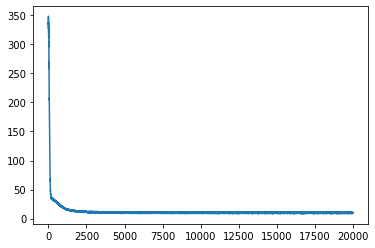

In [305]:
plt.plot(vals)

In [309]:
loss(unreplicate(pstore).params, rng, particle_data[:64], jet_data[:64])

/tmp/ipykernel_68/3086352904.py:2: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  l1, l2, l3 = vdm.apply(params, im.astype("float"), lb, rngs={"sample": rng})


Array(9.338308, dtype=float32)

In [314]:
n_samples = 1000
x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples,), jet_data[:n_samples], guidance_weight=1.)

100%|██████████| 16/16 [00:00<00:00, 82.62it/s]


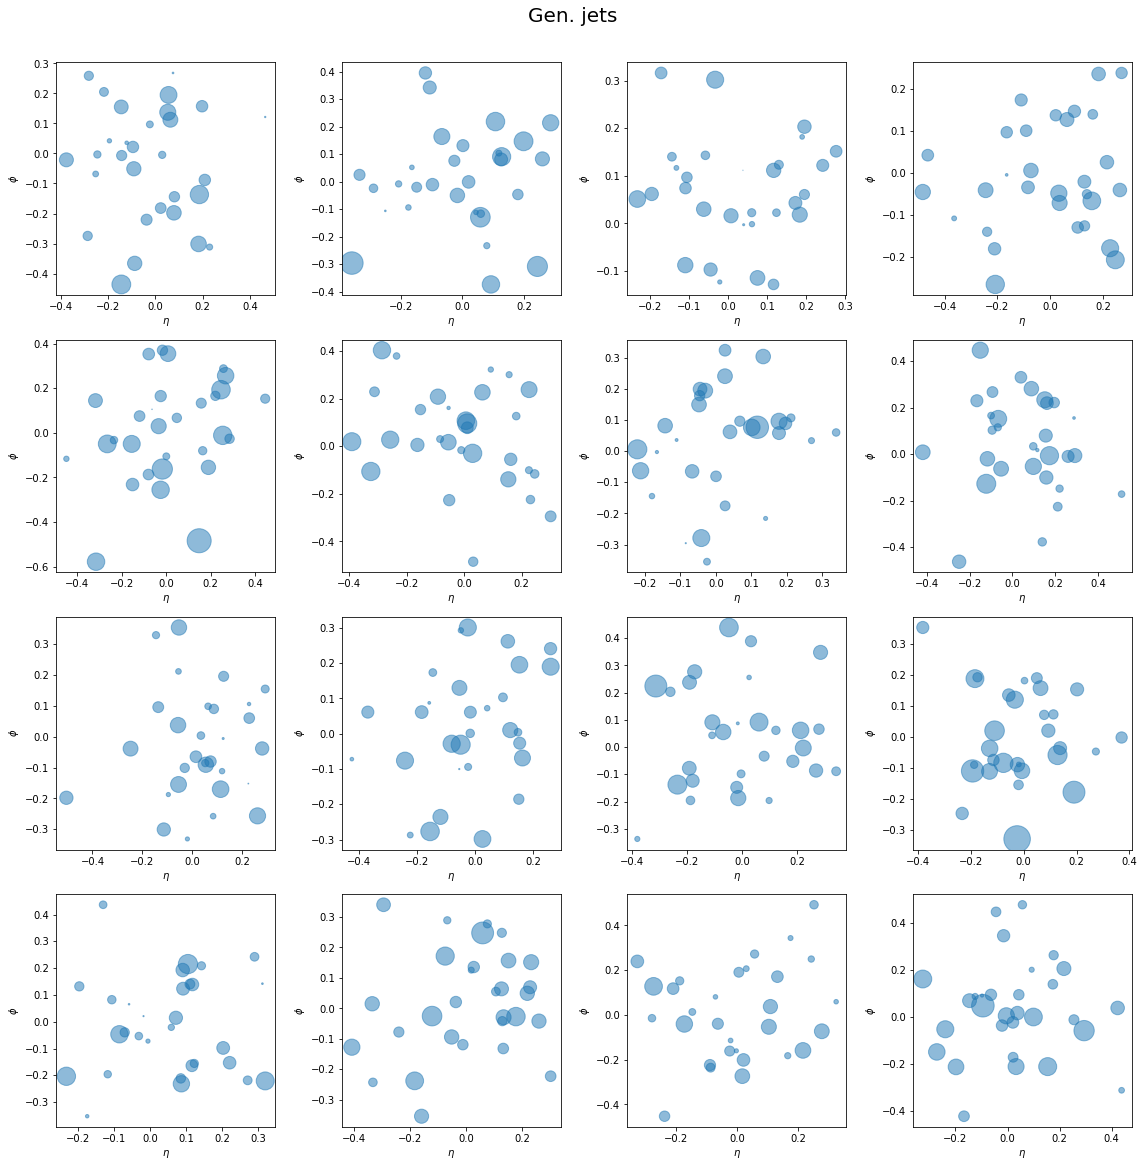

In [315]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * np.abs(x_samples[i, :, 2]), alpha=0.5)  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    # ax.set_xlim(-0.3, 0.3)
    # ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()


In [316]:
x = particle_data[:100]

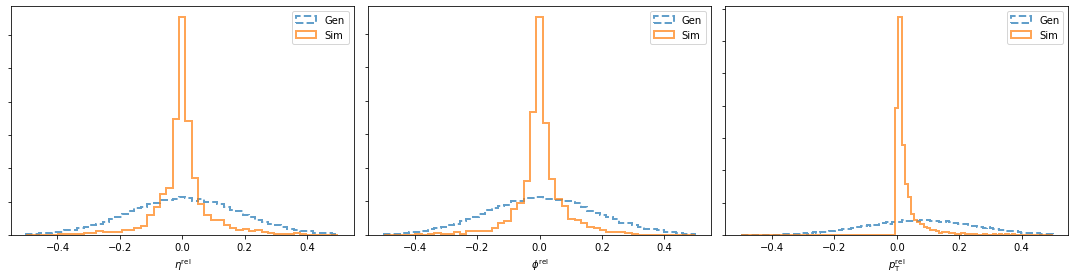

In [317]:
fig = plt.figure(figsize=(20, 4))
gs = GridSpec(1, 4)

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.5, 0.5, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

plt.tight_layout()